# Explore here

In [30]:
# Importar librerías

import pandas as pd
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from pickle import dump

In [3]:
# Cargar los datos

df = pd.read_csv('https://breathecode.herokuapp.com/asset/internal-link?id=932&path=url_spam.csv')
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


Preprocesamiento de datos

In [ ]:
# Validación de duplicados

df.duplicated().sum()

np.int64(630)

In [8]:
df.drop_duplicates(inplace=True)
df.shape

(2369, 2)

In [11]:
# Validar si los datos están balanceados

print(f"Cantidad de SPAM {len(df[df['is_spam']==True])}")
print(f"Cantidad de correos {len(df[df['is_spam']==False])}")

Cantidad de SPAM 244
Cantidad de correos 2125


In [12]:
# Preprocesamiento de texto

import regex as re

def preprocess_text(text):
    # Eliminar cualquier caracter que no sea una letra (a-z) o un espacio en blanco ( )
    text = re.sub(r'[^a-z ]', " ", text)
    
    # Eliminar espacios en blanco
    text = re.sub(r'\s+[a-zA-Z]\s+', " ", text)
    text = re.sub(r'\^[a-zA-Z]\s+', " ", text)

    # Reducir espacios en blanco múltiples a uno único
    text = re.sub(r'\s+', " ", text.lower())

    # Eliminar tags
    text = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

    return text.split()


In [13]:
df['url'] = df['url'].apply(preprocess_text)
df.head()

,url,is_spam
0,"[https, briefingday, us, list, manage, com, un...",True
1,"[https, www, hvper, com]",True
2,"[https, briefingday, com, v, i]",True
3,"[https, briefingday, com, m, commentform]",False
4,"[https, briefingday, com, fan]",True


In [ ]:
# Lematización

download('stopwords')
download('wordnet')

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stop_words.add('com')
stop_words.add('http')
stop_words.add('https')

[nltk_data] Downloading package stopwords to /home/vscode/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...


In [17]:
# Función para lematizar el texto y eliminar stopwords

def lemmatize_text(text, lemmatizer=lemmatizer, stop_words=stop_words):
    tokens = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    tokens = [word for word in tokens if len(word) > 3]
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [19]:
df['url'] = df['url'].apply(lemmatize_text)
df.head()

,url,is_spam
0,"[briefingday, list, manage, unsubscribe]",True
1,[hvper],True
2,[briefingday],True
3,"[briefingday, commentform]",False
4,[briefingday],True


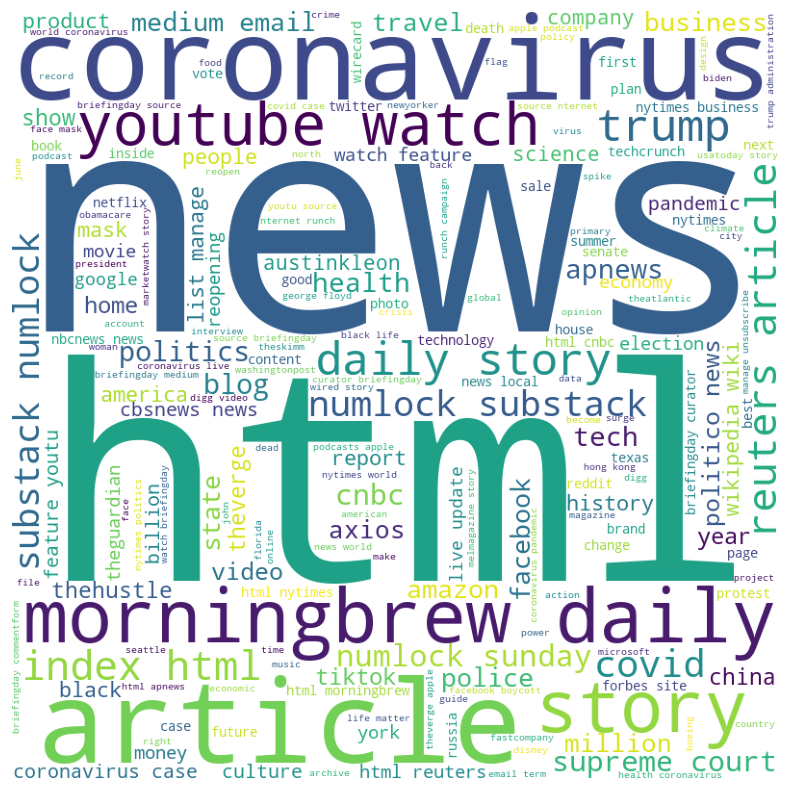

In [22]:
# Visualización

WordCloud = WordCloud(width=800, height=800, background_color='white', max_words=200, random_state=89).generate(df['url'].explode().str.cat(sep=' '))
fig = plt.figure(figsize=(10, 10))
plt.imshow(WordCloud)
plt.axis('off')
plt.show()


In [ ]:
# Transformar a matriz

vectorizer = TfidfVectorizer(max_features=5000, max_df=0.8, min_df=5)
X = df['url']
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=89)

tokens_list = [" ".join(tokens) for tokens in X_train]
tokens_list_2 = [" ".join(tokens) for tokens in X_test]

X_train_vectorized = vectorizer.fit_transform(tokens_list).toarray()
X_test_vectorized = vectorizer.transform(tokens_list_2).toarray()



In [ ]:
# Construir modelo

model = SVC(kernel='linear', C=1.0, random_state=89)
model.fit(X_train_vectorized, y_train)

,C,1.0
,kernel,'linear'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [27]:
# Ejecutar predicciones

y_pred = model.predict(X_test_vectorized)

In [ ]:
# Evaluar el modelo

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy*100:.2f}%")

Accuracy: 93.46%


In [ ]:
# Guardar modelo

dump(model, open('../models/svm_lineal_C_1_42_model.pkl', 'wb'))

CONCLUSIONES:

- Los modelos SVM permiten trabajar con datos a pesar de estar desbalanceados. Útiles para múltiples escenarios.
- Un paso importante al trabajar NLP es el preprocesamiento del texto. Antes de empezar a construir el modelo se requier validar y limpiar el texto eliminando caracteres especiales o cualquier otro que haga "ruido", con el objetivo de optimizar el funcionamiento del modelo.
- Para construir cualquier modelo de ML se debe transformar los textos en matriz